## Car Price Prediction [ EDA and model building]
**Exploratory Data Analysis [EDA]** is a fundamental step in any data science project in which we explore our dataset using various statistical and visual means in order to gather insights that will aid in our data's understanding and  improve our ability to make effective business decisions.  
Continuing from the data cleaning stage, we will advance into exploratory analysis in order to better understand our data, and we will finally build several **machine learning models** for predicting car prices.

In [1]:
# importing required packages
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='white')

In [2]:
df = pd.read_csv("data/cars_cleaned.csv")

In [3]:
df.head()

,Brand,Model,Year,Mileage,Condition,Price,Number of Cylinders,Engine Capacity,Ratings,Color
0,Toyota,Corolla,2015,186024,Foreign Used,7530000,4.0,1000.0,4.2,Grey
1,Mercedes-Benz,GLK 350,2015,87465,Foreign Used,13530000,6.0,3000.0,4.5,black
2,Toyota,Highlander,2008,142719,Foreign Used,7230000,6.0,3500.0,4.4,Red
3,Toyota,Sienna,2006,115232,Foreign Used,4880000,6.0,3000.0,4.5,gold
4,Honda,Crosstour,2012,120661,Foreign Used,5030000,6.0,3000.0,4.5,Silver


In [4]:
#columns in the dataset
df.columns

Index(['Brand', 'Model', 'Year', 'Mileage', 'Condition', 'Price',
       'Number of Cylinders', 'Engine Capacity', 'Ratings', 'Color'],
      dtype='object')

In [5]:
print(f"Number of Car brands {len(df['Brand'].value_counts())}")
df["Brand"].value_counts()[:10]

Number of Car brands 22


Toyota           1193
Lexus             256
Honda             188
Mercedes-Benz     175
Hyundai            77
Ford               71
Kia                45
Nissan             42
Land Rover         26
Acura              25
Name: Brand, dtype: int64

In [6]:
print(f"Number of Car Models {len(df['Model'].value_counts())}")
df["Model"].value_counts()

Number of Car Models 110


Camry         375
Corolla       304
Highlander    144
Sienna         89
Accord         84
             ... 
ES 330          3
IS 250          3
C350            3
Liberty         3
RX              3
Name: Model, Length: 110, dtype: int64

**Top Ten** Most Popular Car Brands Sold 

<AxesSubplot:xlabel='Brand'>

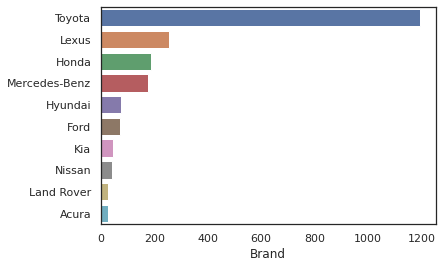

In [7]:
top10_brands = df["Brand"].value_counts()[:10]
sns.barplot(x= top10_brands , y = top10_brands.index)

**Top 10** Most popular car models sold 

<AxesSubplot:xlabel='Model'>

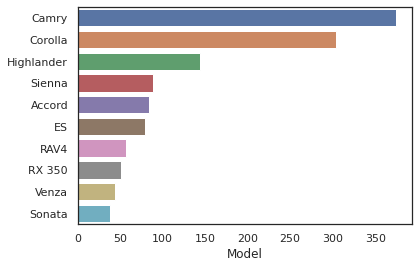

In [8]:
top10_models = df["Model"].value_counts()[:10]
sns.barplot(x= top10_models , y = top10_models.index)

**Car Prices** increasing with year

<AxesSubplot:xlabel='Year', ylabel='Price'>

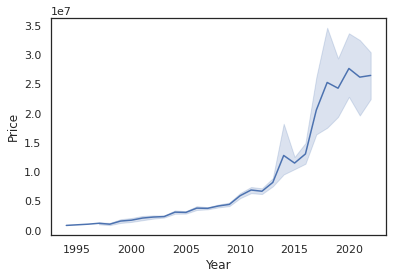

In [9]:
# Prices of cars increases as the year of the model increases
sns.lineplot(data=df,x='Year',y='Price')

**The Condition** of a car has a positive impact on the price of a car, with brand new cars being more expensive than used cars by a huge magnitude.

<AxesSubplot:xlabel='Condition', ylabel='Price'>

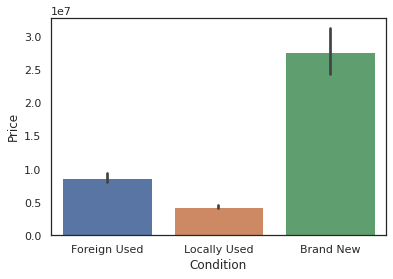

In [10]:
# condition of car has a high effect on the price of the car
sns.barplot(data=df,x='Condition',y='Price')

<AxesSubplot:xlabel='Price', ylabel='Color'>

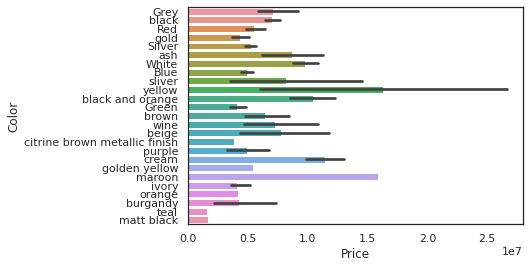

In [11]:
## too much variation and outliers in the data to see if color has an effect on the price of car
sns.barplot(data=df,y='Color',x='Price')

**Number of cylinders** seems to have a positive correlation with the price of a car but due to the small size of the dataset, the trend cannot be fully shown

,Number of Cylinders,Price
Number of Cylinders,1.000000,0.238614
Price,0.238614,1.000000


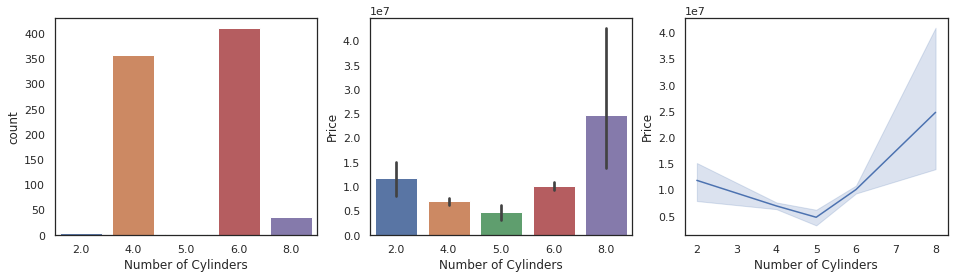

In [12]:
# plotting the number of cylinders
fig,axes = plt.subplots(1,3)
fig.set_figheight(4), 
fig.set_figwidth(16)
sns.countplot(data=df,x='Number of Cylinders',ax=axes[0])
sns.barplot(data=df,x='Number of Cylinders',y='Price',ax=axes[1])
sns.lineplot(data=df,x='Number of Cylinders',y='Price',ax=axes[2])
df[['Number of Cylinders','Price']].corr()

In [13]:
df[["Model","Year"]].value_counts()

Model    Year
Camry    2007    70
         2009    42
Corolla  2009    39
Camry    2012    39
Corolla  2005    34
                 ..
HiAce    2010     1
Golf     2012     1
         2009     1
         2006     1
Yaris    2020     1
Length: 648, dtype: int64

Due to the fact that car models released in the same year usually have the same **Number of Cylinders** and **Engine Capacity** we can impute missing values in the **Number of Cylinders** and **Engine Capacity** columns through this fact

In [14]:
model_year_cylinders = dict(df.groupby(["Model",'Year'])["Number of Cylinders"].apply(lambda x:np.floor(np.mean(x))))
model_year_engine_capacity = dict(df.groupby(["Model",'Year'])["Engine Capacity"].apply(lambda x:np.floor(np.mean(x))))

In [15]:
def approx_num_of_cylinders(x):
    if x.name != 'Number of Cylinders':
        return x
    for index,val in enumerate(x.isna()):
        if val == True:
            c = df.iloc[index]
            c = (c['Model'],c['Year'])
            d = model_year_cylinders[c]
            x[index]=d
    return x

def approx_engine_capacity(x):
    if x.name != 'Engine Capacity':
        return x
    for index,val in enumerate(x.isna()):
        if val == True:
            c = df.iloc[index]
            c = (c['Model'],c['Year'])
            d = model_year_engine_capacity[c]
            x[index]=d
    return x

In [16]:
## approximating the num of cylinders by the car year and model
df = df.apply(approx_num_of_cylinders)

In [17]:
## approximating the engine capacity by the car year and model
df = df.apply(approx_engine_capacity)

### Model Building
We are going to train and fine tune 3 machine learning models which are listed below:  
- **Ridge**
- **Decision Tree**
- **Random Forest**

In [68]:
# importing packages for building our model

from sklearn.linear_model import  Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OrdinalEncoder,StandardScaler,PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.impute import KNNImputer

In [19]:
## Creating our train and test set
train,test = train_test_split(df,test_size=0.15,stratify=df['Model'])

 ### Mean Target Encoding
Due to the sheer number of categorical values in the **Brand** and **Model** columns, we are going to use their target mean encoding instead of one hot encoding to represent them in our models.

In [20]:
# getting the average price per brand
brand_encoding_dict  =  dict(train.groupby("Brand")['Price'].mean().sort_values(ascending=False))
model_encoding_dict  =  dict(train.groupby("Model")['Price'].mean().sort_values(ascending=False))

In [21]:
train = train.assign(brand_mean_encoding= train['Brand'].apply(lambda x: brand_encoding_dict[x]),
                     model_mean_encoding = train['Model'].apply(lambda x:model_encoding_dict[x]))

test = test.assign(brand_mean_encoding= test['Brand'].apply(lambda x: brand_encoding_dict[x]),
                     model_mean_encoding = test['Model'].apply(lambda x:model_encoding_dict[x]))

X_train=train.drop('Price', axis =1)
y_train = train['Price']

X_test = test.drop("Price",axis=1)
y_test = test['Price']

In [65]:
## creating a pipeline
con_order = [['Locally Used','Foreign Used',"Brand New"]]
pipeline = ColumnTransformer([
        ("ordinal_condition",OrdinalEncoder(categories=con_order),['Condition']),
        ("scaler",StandardScaler(),['brand_mean_encoding','model_mean_encoding','Mileage']),
        ("impute",KNNImputer(),['Engine Capacity','Number of Cylinders']),
        ("drop","drop",["Ratings","Color",'Brand','Model'])
],remainder='passthrough')
pipe_reg = pipeline.fit(X_train)
X_pipeline = pipe_reg.transform(X_train)

### 1. Ridge Regression
We are going to create our first model,using ridge regression model and polynomial features.

In [58]:
## using polynomial feature with the pipeline
X_pipeline_ridge = PolynomialFeatures(degree=3).fit_transform(X_pipeline)

In [59]:
ridge_param_grid={'alpha':[0.1,0.01,1,10,100]}

gs_ridge = GridSearchCV(Ridge(solver='svd'),param_grid=ridge_param_grid,scoring="neg_mean_absolute_error")
gs_ridge.fit(X_pipeline_ridge,y_train)
gs_ridge.best_estimator_

Ridge(alpha=100, solver='svd')

In [66]:
## using the best model from GridSearchCV
ridge = Ridge(alpha=100,solver='svd')
ridge.fit(X_pipeline_ridge,y_train);

pred = ridge.predict(X_pipeline_ridge)
mae_ridge = mean_absolute_error(pred,y_train)
print(f"Mean Absolute Error Score using Ridge :{mae_ridge:.0f}")

Mean Absolute Error Score using Ridge :1674548


## 2. Decision Tree
We are going to create our second model using decision tree

In [45]:
dt_param_grid={
    'max_depth':[5,7,9],
    'criterion':["absolute_error"],
    'min_samples_leaf': [2,3,4],
    'min_samples_split':[2,3,4],
              }

gs_tree = GridSearchCV(DecisionTreeRegressor(),param_grid=dt_param_grid,scoring="neg_mean_absolute_error",cv=3)
gs_tree.fit(X_pipeline,y_train)
gs_tree.best_estimator_

DecisionTreeRegressor(criterion='absolute_error', max_depth=7,
                      min_samples_leaf=2, min_samples_split=4)

In [67]:
tree = DecisionTreeRegressor(criterion='absolute_error', max_depth=7, min_samples_leaf=2,min_samples_split=4)
tree.fit(X_pipeline,y_train)

pred = tree.predict(X_pipeline)
mae_tree = mean_absolute_error(pred,y_train)
print(f"Mean Absolute Error Score using Decision Tree :{mae_tree:.0f}")

Mean Absolute Error Score using Decision Tree :1019814


## 3. Random Forest
Finally, we are going to create the last model, which is the Random Forest

In [47]:
rf_param_grid={
    'max_depth':[7,9],
    'criterion':['absolute_error'],
    'min_samples_split':[2,3,4,5],
    'min_samples_leaf':[2,3,4,5],
    }
gs_rf = GridSearchCV(RandomForestRegressor(),param_grid=rf_param_grid,scoring="neg_mean_absolute_error",cv=3)
gs_rf.fit(X_pipeline,y_train)
gs_rf.best_estimator_

RandomForestRegressor(criterion='absolute_error', max_depth=9,
                      min_samples_leaf=3, min_samples_split=3)

In [48]:
rf = RandomForestRegressor(criterion='absolute_error', max_depth=9, min_samples_leaf=3,min_samples_split=3)
rf.fit(X_pipeline,y_train)

pred = rf.predict(X_pipeline)
mae_rf = mean_absolute_error(pred,y_train)
print(f"Mean Absolute Error Score using Random Forest:{mae_rf:.0f}")

Mean Absolute Error Score using Random Forest:934507


#### Evaluating on the test set
Since the Random Forest model outperformed all other models on the training and test sets, we are going to use that as our final model and evaluate it on the test set

In [49]:
Xt_pipeline = pipe_reg.transform(X_test)
pred = rf.predict(Xt_pipeline)
mae_rf = mean_absolute_error(pred,y_test)
print(f"Mean Absolute Error Score using Random Forest:{mae_rf:.0f}")

#for references
mae_tree = mean_absolute_error(tree.predict(Xt_pipeline),y_test)
print(f"Mean Absolute Error Score using Decision Tree:{mae_tree:.0f}")

Mean Absolute Error Score using Random Forest:1139024
Mean Absolute Error Score using Decision Tree:1347475


### Saving The Best Model
We are finally done with our machine learning model, and we are going to save it so that it can be used in production

In [50]:
import pickle
pickl = {'model': gs_rf.best_estimator_,
         "brand_encoding_dict":brand_encoding_dict,
         "model_encoding_dict":model_encoding_dict,
         "pipeline":pipeline,
        }
pickle.dump( pickl, open( 'saved_model' + ".pkl", "wb" ) )